### aim: figure MAP, figure hovmoller, figure means_extremes for winds paper, regridded

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

    need: 
        - taux, tauy, and wspd (ORCA grid), for: 
            - ERA5_v202303
            - All 6 UKESM scenarios
            - UKESM PI scenario
            
        - regridded windspeed for:
            - UKESM, scen 1A to 1940-2020
            - ERA5_v202303 1940-2020 
            
taux and tauy made in `SOZONE/windAnalyis/paperFigures/runnerMakeGoodDatesForTauxTauy.py`
wspd made in `SOZONE/windAnalyis/paperFigures/runnerMakeWspd.py`
preparation for regridding made in `runnerLatLonsForRegrid.py` script, regridding made in a `regridWindsWithCDO.sh` script in this dir

## Figure means and extremes

In [4]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

#### need to calculate s30 and s50 (south of -30 and south of -50)

In [5]:
###broadcasted cell size
w2 = xr.open_dataset('//gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_19900101_19901231_ptrc_T.nc')
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
csize_broad = np.zeros([365, 149, 182])

for i in range(0,365):
    csize_broad[i,:] = tmesh['csize']

boundary_so = 37

def get_wind_extremes_and_maps_s50(yr, product = 'ukesm', verbose = False):

    tdir = '/gpfs/data/greenocean/software/resources/windsProcessed/'

    print(f'{yr}, {product}')
    if product == 'ukesm':
        if (yr < 2015):
            wind = xr.open_dataset(f'{tdir}/UKESM_1H_wspd_{yr}_daily.nc')
        else:
            wind = xr.open_dataset(f'{tdir}/UKESM_1FA_wspd_{yr}_daily.nc')
    elif product == 'era5':
        wind = xr.open_dataset(f'{tdir}/ERA5_v2023_wspd_{yr}_daily.nc')
    else:
        print('gonewrong')
        taux = 3
        tauy = 3


    
    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left') 
    if product == 'ukesm':
        times = times[~((times.month == 2) & (times.day == 29))] #exclude leap years for ukesm
    wind['time_counter'] = times

    seas = ['DJF','MAM', 'JJA', 'SON']

    seasmean_map = np.zeros([4,boundary_so,182])
    seasmean = np.zeros(4)
    seas95 = np.zeros(4)
    seasextrema = np.zeros(4)
    
    for i in range(0,len(seas)):
        tseas = seas[i]
        twspd = wind.wspd.sel(time_counter=wind['time_counter.season']==tseas).values

        dis = (np.shape(twspd)[0]) #days in season
        weightedmean = np.ma.average(twspd[:,0:boundary_so,:], weights = csize_broad[0:dis,0:boundary_so,:])
        seasmean[i] = weightedmean
        perc95 = weighted_quantile(np.ravel(twspd[:,0:boundary_so,:]), 0.95, sample_weight=np.ravel(csize_broad[0:dis,0:boundary_so,:]))
        seas95[i] = perc95
        
        extrema = twspd[twspd > perc95]
        meanextreme = np.nanmean(extrema)
        seasextrema[i] = meanextreme
        
        if verbose:
            print(f'{tseas}, mean wind {weightedmean}, 95th percentile winds: {perc95}, mean of top 5%: {meanextreme}')

        seasmean_map[i,:,:] = np.nanmean(twspd[:,0:boundary_so,:], axis = 0)
            
    return seasmean_map, seasmean, seas95, seasextrema

syear = 1940
seasmean_map_ts_ukesm_s50 = np.zeros([2020-syear,4,boundary_so,182])
seasmean_ts_ukesm_s50 = np.zeros([2020-syear,4])
seas95_ts_ukesm_s50 = np.zeros([2020-syear,4])
seasextrema_ts_ukesm_s50 = np.zeros([2020-syear,4])

seasmean_map_ts_era_s50 = np.zeros([2020-syear,4,boundary_so,182])
seasmean_ts_era_s50 = np.zeros([2020-syear,4])
seas95_ts_era_s50 = np.zeros([2020-syear,4])
seasextrema_ts_era_s50 = np.zeros([2020-syear,4])

for yr in range(syear,2020):
    seasmean_map_ts_era_s50[yr-syear,:,:,:], seasmean_ts_era_s50[yr-syear,:], seas95_ts_era_s50[yr-syear,:], seasextrema_ts_era_s50[yr-1950,:] = \
        get_wind_extremes_and_maps_s50(yr, product = 'era5', verbose = False)
    seasmean_map_ts_ukesm_s50[yr-syear,:,:,:], seasmean_ts_ukesm_s50[yr-1950,:], seas95_ts_ukesm_s50[yr-1950,:], seasextrema_ts_ukesm_s50[yr-1950,:] = \
        get_wind_extremes_and_maps_s50(yr, product = 'ukesm', verbose = False)


1940, era5
1940, ukesm
1941, era5
1941, ukesm
1942, era5
1942, ukesm
1943, era5
1943, ukesm
1944, era5
1944, ukesm
1945, era5
1945, ukesm
1946, era5
1946, ukesm
1947, era5
1947, ukesm
1948, era5
1948, ukesm
1949, era5
1949, ukesm
1950, era5
1950, ukesm
1951, era5
1951, ukesm
1952, era5
1952, ukesm
1953, era5
1953, ukesm
1954, era5
1954, ukesm
1955, era5
1955, ukesm
1956, era5
1956, ukesm
1957, era5
1957, ukesm
1958, era5
1958, ukesm
1959, era5
1959, ukesm
1960, era5
1960, ukesm
1961, era5
1961, ukesm
1962, era5
1962, ukesm
1963, era5
1963, ukesm
1964, era5
1964, ukesm
1965, era5
1965, ukesm
1966, era5
1966, ukesm
1967, era5
1967, ukesm
1968, era5
1968, ukesm
1969, era5
1969, ukesm
1970, era5
1970, ukesm
1971, era5
1971, ukesm
1972, era5
1972, ukesm
1973, era5
1973, ukesm
1974, era5
1974, ukesm
1975, era5
1975, ukesm
1976, era5
1976, ukesm
1977, era5
1977, ukesm
1978, era5
1978, ukesm
1979, era5
1979, ukesm
1980, era5
1980, ukesm
1981, era5
1981, ukesm
1982, era5
1982, ukesm
1983, era5


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


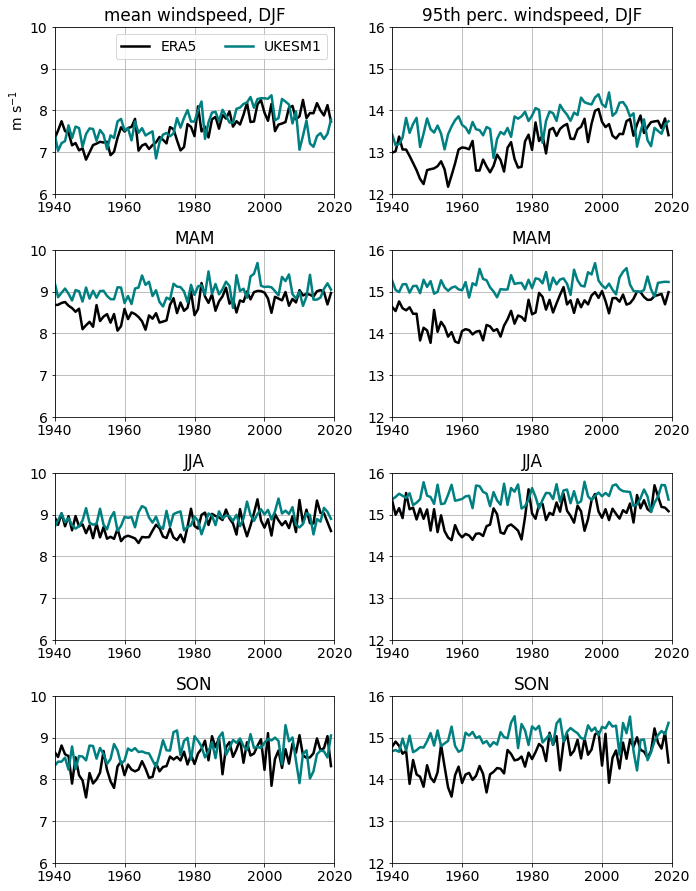

In [7]:
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 14}

fact = 0.9
fig, axs = plt.subplots(4,2, figsize=(11*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

lw = 2.5
##spring
yrs = np.arange(1940,2020,1)

mnmi = 6; mnma = 10

i = 0
axs[i].plot(yrs,seasmean_ts_era_s50[:,0], linewidth = lw, color = 'black', label = 'ERA5')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,0], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 2
axs[i].plot(yrs,seasmean_ts_era_s50[:,1], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,1], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 4
axs[i].plot(yrs,seasmean_ts_era_s50[:,2], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,2], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 6
axs[i].plot(yrs,seasmean_ts_era_s50[:,3], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,3], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])

mnmi = 12; mnma = 16
i = 0+1
axs[i].plot(yrs,seas95_ts_era_s50[:,0], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,0], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 2+1
axs[i].plot(yrs,seas95_ts_era_s50[:,1], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,1], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 4+1
axs[i].plot(yrs,seas95_ts_era_s50[:,2], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,2], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 6+1
axs[i].plot(yrs,seas95_ts_era_s50[:,3], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,3], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])

tits  = ['mean windspeed, DJF','95th perc. windspeed, DJF',
        'MAM','MAM',
        'JJA','JJA',
        'SON','SON']

for p in range(0,8):
    axs[p].grid(); 
    axs[p].set_xticks(np.arange(1940,2050,20), fontsize = 10)
    axs[p].set_xlim([1940,2020])
    if p == 0:
        axs[p].set_ylabel('m s$^{-1}$')
        #axs[p].set_ylim([6.5,16])
    axs[p].set_title(tits[p])
    
    axs[0].legend(ncol = 2, loc = 'best')
        
#plt.suptitle('Wind Speed Statistic comparison UKESM1 vs ERA5, \n calculated from spatiotemporal averages (ie all days and points in a given season and year, weighted by cell size) \n Southern Ocean <-30S')
plt.tight_layout()
#fig.savefig('./figs/meanex.jpg', dpi = 300)

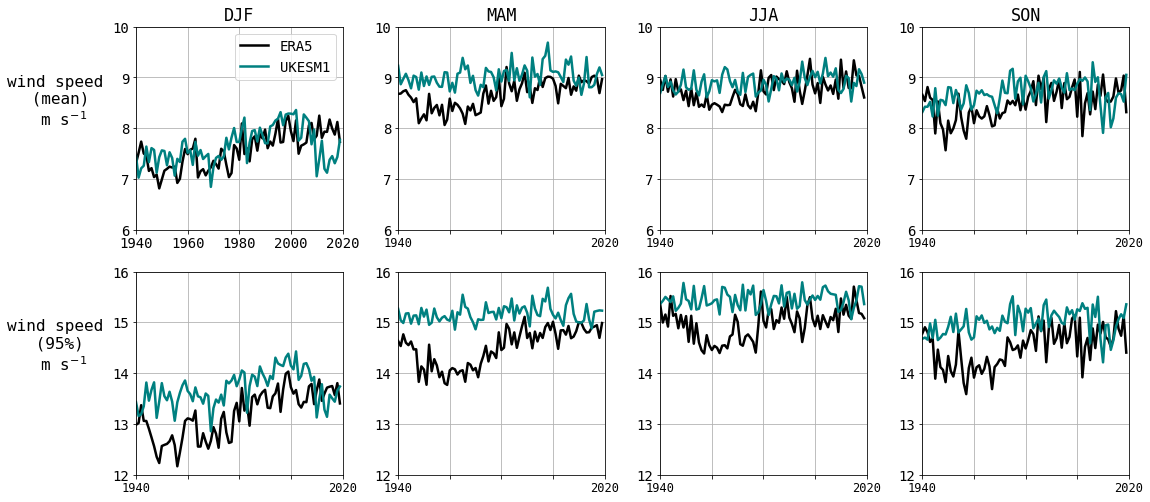

In [8]:
plt.rcParams.update({'font.size': 12})
font = {'family' : 'monospace',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 14}

fact = 0.9
fig, axs = plt.subplots(2,4, figsize=(18*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

lw = 2.5
##spring
yrs = np.arange(1940,2020,1)

mnmi = 6; mnma = 10

i = 0
axs[i].plot(yrs,seasmean_ts_era_s50[:,0], linewidth = lw, color = 'black', label = 'ERA5')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,0], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 1
axs[i].plot(yrs,seasmean_ts_era_s50[:,1], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,1], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 2
axs[i].plot(yrs,seasmean_ts_era_s50[:,2], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,2], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 3
axs[i].plot(yrs,seasmean_ts_era_s50[:,3], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,3], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])

mnmi = 12; mnma = 16
i = 4
axs[i].plot(yrs,seas95_ts_era_s50[:,0], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,0], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 5
axs[i].plot(yrs,seas95_ts_era_s50[:,1], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,1], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 6
axs[i].plot(yrs,seas95_ts_era_s50[:,2], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,2], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])
i = 7
axs[i].plot(yrs,seas95_ts_era_s50[:,3], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
axs[i].plot(yrs,seas95_ts_ukesm_s50[:,3], linewidth = lw, color = 'teal', label = 'UKESM1')
axs[i].set_ylim([mnmi,mnma])

tits  = ['DJF',
        'MAM',
        'JJA',
        'SON',]

for p in range(0,8):
    axs[p].grid(); 
    axs[p].set_xticks(np.arange(1940,2050,20), fontsize = 12)
    axs[p].set_xlim([1940,2020])

    axs[0].legend(ncol = 1, loc = 'best')
    
for p in range(0,4):
    axs[p].set_title(tits[p])

axs[0].set_ylabel('wind speed           \n (mean)           \n m s$^{-1}$           ', 
                  rotation = 0, fontsize = 16)
axs[4].set_ylabel('wind speed           \n (95%)           \n m s$^{-1}$           ', 
                  rotation = 0, fontsize = 16)
axs[0].legend(ncol = 1, loc = 'best')

for i in range(1,8):
    axs[i].set_xticks(np.arange(1940,2030,20))
    axs[i].set_xticklabels(['1940','','','','2020'], fontsize = 12)
#plt.suptitle('Wind Speed Statistic comparison UKESM1 vs ERA5, \n calculated from spatiotemporal averages (ie all days and points in a given season and year, weighted by cell size) \n Southern Ocean <-30S')
plt.tight_layout()
#fig.savefig('./figs/meanex.jpg', dpi = 300)

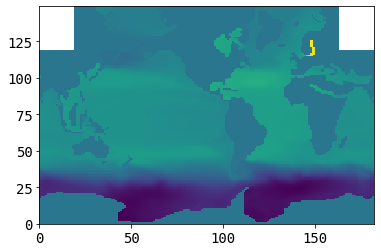

In [9]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_GEA1/ORCA2_1m_20220101_20221231_ptrc_T.nc')

plt.pcolormesh(w.C14B[0,0,:,:].values)

## Figure climatology map

climatologies made in `/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/paperFigures/runnerMakeClimatologyWspd.py`

In [7]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = 8)
        cb.set_ticks(tticks, fontsize = 80)
        cb.ax.tick_params(labelsize=8)
    return cb

In [8]:
tdir = '/gpfs/data/greenocean/software/resources/windsProcessed/'

ukesm_clim = 'UKESM_1H_wspd_clim_1940-2020_regrid.nc'
era5_clim = 'ERA5_wspd_clim_1940-2020_regrid.nc'

ukesm_winds = xr.open_dataset(f'{tdir}/{ukesm_clim}')
era5_winds = xr.open_dataset(f'{tdir}/{era5_clim}')

In [9]:
ukesm_winds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, season: 5)
Coordinates:
  * season   (season) object 'FY' 'DJF' 'MAM' 'JJA' 'SON'
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    wspd     (season, lat, lon) float64 ...
Attributes:
    made in:  SOZONE/windAnalyis/paperFigures/runnerMakeClimatologyWspd.py
    desc:     yearly medusa files, saving only variables of interest

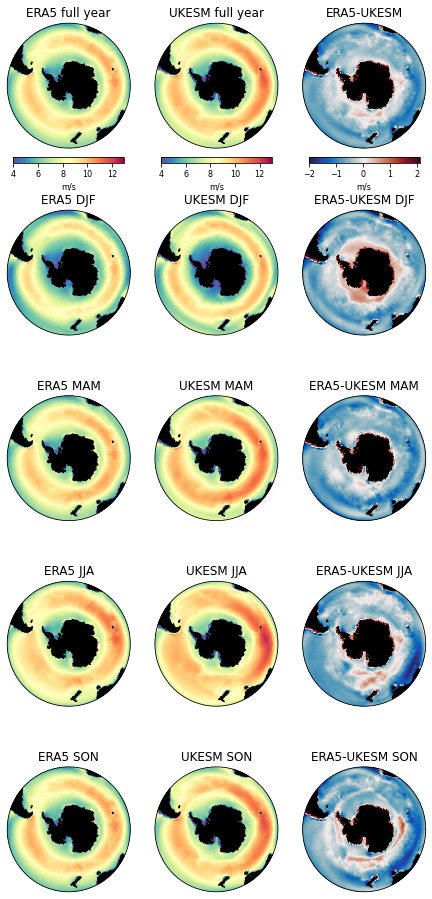

In [14]:
spbot = 4; sptop = 13; spint = 2
difbot = -2; diftop = 2.1; difint = 1
tcm = 'Spectral_r'

lats = era5_winds.lat
lons = era5_winds.lon

fact = 0.25
fig = plt.figure(figsize=[30*fact, 66*fact])


tits = ['ERA5 full year', 'UKESM full year', 'ERA5-UKESM',
       'ERA5 DJF', 'UKESM DJF', 'ERA5-UKESM DJF','ERA5 MAM', 'UKESM MAM', 'ERA5-UKESM MAM',\
        'ERA5 JJA', 'UKESM JJA', 'ERA5-UKESM JJA','ERA5 SON', 'UKESM SON', 'ERA5-UKESM SON']

toplot = [era5_winds.wspd[0,:,:].values, ukesm_winds.wspd[0,:,:].values,\
          era5_winds.wspd[0,:,:].values -ukesm_winds.wspd[0,:,:].values,\
          era5_winds.wspd[1,:,:].values, ukesm_winds.wspd[1,:,:].values,\
          era5_winds.wspd[1,:,:].values -ukesm_winds.wspd[1,:,:].values,\
          era5_winds.wspd[2,:,:].values, ukesm_winds.wspd[2,:,:].values,\
          era5_winds.wspd[2,:,:].values -ukesm_winds.wspd[2,:,:].values,\
          era5_winds.wspd[3,:,:].values, ukesm_winds.wspd[3,:,:].values,\
          era5_winds.wspd[3,:,:].values -ukesm_winds.wspd[3,:,:].values,\
          era5_winds.wspd[4,:,:].values, ukesm_winds.wspd[4,:,:].values,\
          era5_winds.wspd[4,:,:].values -ukesm_winds.wspd[4,:,:].values,\
         ]
      
cms = [tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance]
bb = [spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot, spbot, spbot, difbot]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop, sptop, sptop, diftop]
intvl = [spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint]
#test = seasmean_map_ts_ukesm[0,0,:,:]


for i in range(0,15):
    test = toplot[i]
    botbound = bb[i]
    topbound = tb[i]
    tint = intvl[i]
    if i < 3:
        tcbr = True
    else:
        tcbr = False
    ax1 = fig.add_subplot(5, 3, i+1, projection=ccrs.Orthographic(0, -90))
    bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                  topbound, np.arange(botbound,topbound,tint), fs = 12, 
                  tit = tits[i], cbarlab = 'm/s', tcmap = cms[i], lm = True, cbr = tcbr)
    
#plt.suptitle('seasonal wind speed climatology, 1950-2020', y = 0.90)
plt.tight_layout()
fig.savefig('./figs/Fig_climatologymap_UKESM_ERA.jpg', dpi = 300)

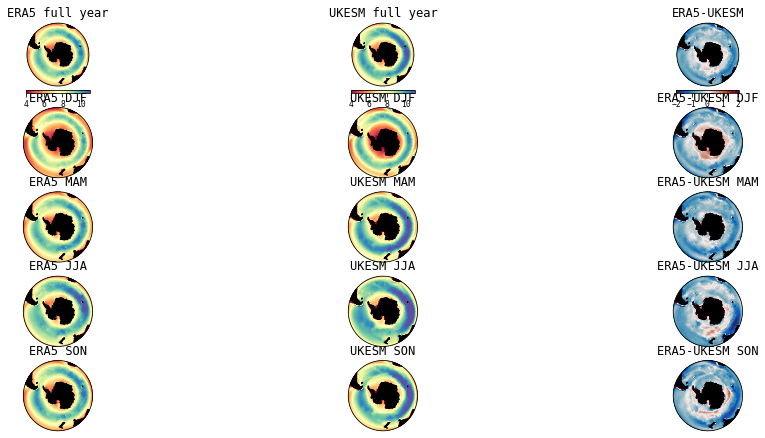

### Figure hovmoller

In [14]:
## make binary landmask - weights on an equal grid are simple, by definition. glodap's grid is shifted for whatever reason
w = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TCO2.nc')
w2 = xr.open_dataset('/gpfs/data/greenocean/software/resources/windsProcessed/UKESM_1FA_wspd_2021_regridded.nc') #get lats and lons from here

mmask_unrot = w.TCO2[0,:,:].values
mmask_unrot[mmask_unrot >0] =1
mmask_unrot[np.isnan(mmask_unrot)] = 0 

## rotate glodap mask to match cdo mask
mmask_rot = np.zeros_like(mmask_unrot)
mmask_rot[:,0:20] = mmask_unrot[:,340:360]
mmask_rot[:,20:360] = mmask_unrot[:,0:340]

# plt.figure()
# plt.pcolormesh(mmask_unrot)
# plt.figure()
# plt.pcolormesh(mmask_rot)

savenam = 'test2.nc'
data_vars = {'mask':(['lat', 'lon'], mmask_rot,
    {'units': 'µatm',
    'long_name':'Surface ocean pCO2'}),
    }
# define coordinates
coords = {
    'lat': (['lat'], w2.lat),
    'lon': (['lon'], w2.lon),
    }
# define global attributes
attrs = {'made in':'SOZONE/windAnalyis/paperFigures/regridded_partAfigures.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
cdo_mask = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)

In [15]:
def make_yearlist(yrst, yrend, tr = 'UKESM'):
    
    baseDir = '/gpfs/data/greenocean/software/resources/windsProcessed/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        if tr == 'UKESM':
            if yr <2015:
                scen = '1H'
            else:
                scen = '1FA'
            ty = f'{baseDir}/{tr}_{scen}*wspd*{yrs[i]}*regridded.nc'
            t2 = glob.glob(ty)
        if tr == 'ERA5':
            ty = f'{baseDir}/{tr}_v2023*wspd*{yrs[i]}*regridded.nc'
            t2 = glob.glob(ty)
        #print(t2[0])
        ylist.append(t2[0])
    return ylist

tylist_ukesm = make_yearlist(1940,2019)
ukesm_wind = xr.open_mfdataset(tylist_ukesm)
tylist_era = make_yearlist(1940,2019, tr = 'ERA5')
era_wind = xr.open_mfdataset(tylist_era)

hovmol_ukesm = ukesm_wind.isel(lat = slice(0,60)).weighted(cdo_mask.mask.isel(lat = slice(0,60))).mean(dim = ['lon'])
hovmol_era5 = era_wind.isel(lat = slice(0,60)).weighted(cdo_mask.mask.isel(lat = slice(0,60))).mean(dim = ['lon'])


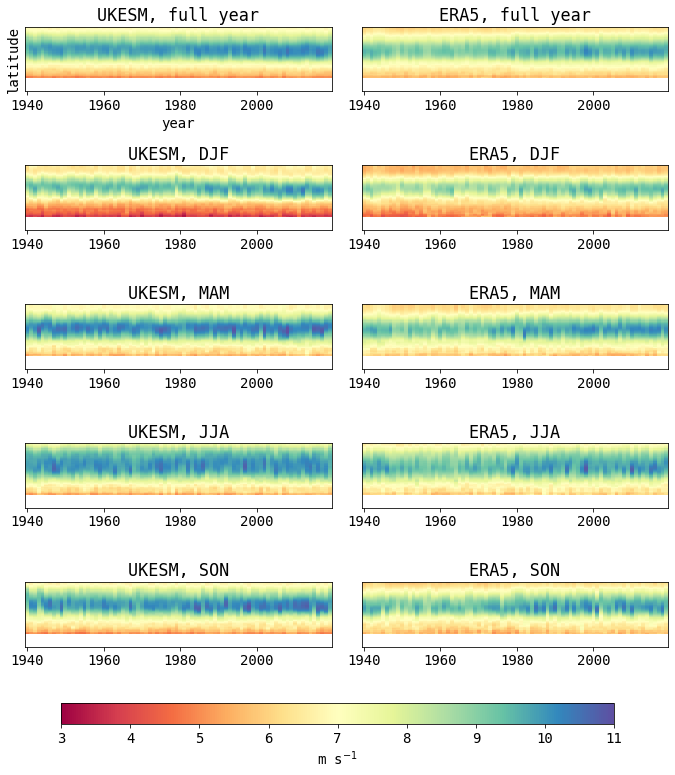

In [16]:
tvmin = 3; tvmax = 11

fact = 0.8
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()

ind = 0
test = hovmol_ukesm.wspd.groupby('time_counter.year').mean().T
w = xr.plot.pcolormesh(test, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')


ind = 1
test = hovmol_era5.wspd.groupby('time_counter.year').mean().T
w = xr.plot.pcolormesh(test, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')

# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
# axs[0].set_ylabel('latitude')

axs[0].set_title('UKESM, full year')
axs[2].set_title('UKESM, DJF')
axs[4].set_title('UKESM, MAM')
axs[6].set_title('UKESM, JJA')
axs[8].set_title('UKESM, SON')


axs[0+ind].set_title('ERA5, full year')
axs[2+ind].set_title('ERA5, DJF')
axs[4+ind].set_title('ERA5, MAM')
axs[6+ind].set_title('ERA5, JJA')
axs[8+ind].set_title('ERA5, SON')

for i in range(1,10):

    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
axs[0].set_ylabel('latitude')    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
plt.tight_layout()
plt.show()
#fig.savefig('./figs/Fig-hovmoller-raw.jpg')

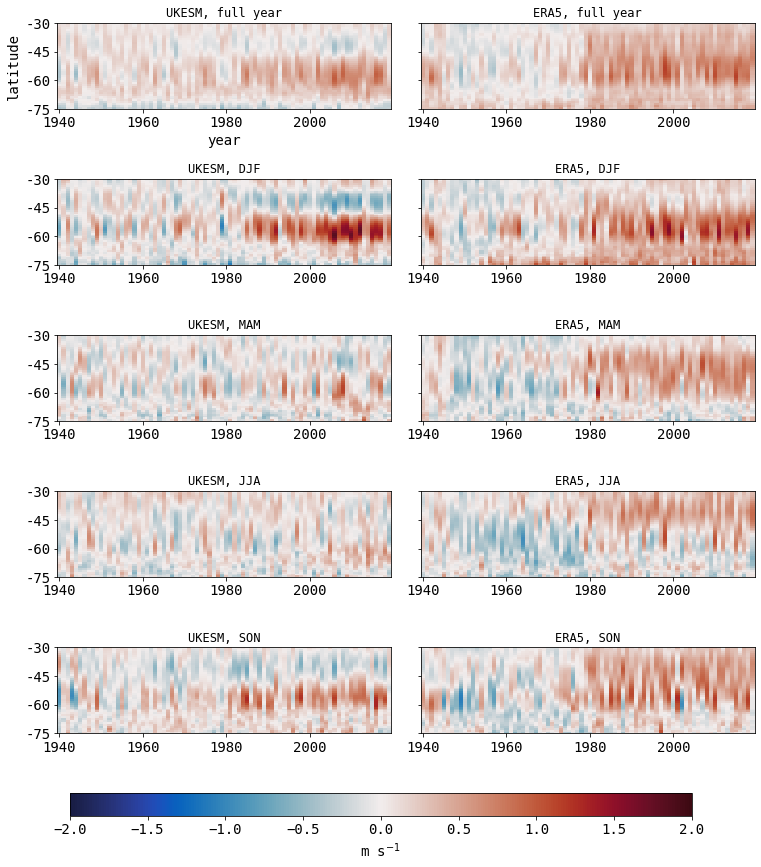

In [17]:
tvmin = -2; tvmax = 2
tcm = cm.balance

fact = 0.9
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()

ind = 0
test = hovmol_ukesm.wspd.groupby('time_counter.year').mean().T
test_1950 = hovmol_ukesm.wspd.sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
w = xr.plot.pcolormesh(test - test_1950, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)


test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
#########
ind = 1
test = hovmol_era5.wspd.groupby('time_counter.year').mean().T
test_1950 = hovmol_era5.wspd.sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
w = xr.plot.pcolormesh(test - test_1950, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1950, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)


# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
# axs[0].set_ylabel('latitude')
fs = 12

axs[0].set_title('UKESM, full year', fontsize = fs)
axs[2].set_title('UKESM, DJF', fontsize = fs)
axs[4].set_title('UKESM, MAM', fontsize = fs)
axs[6].set_title('UKESM, JJA', fontsize = fs)
axs[8].set_title('UKESM, SON', fontsize = fs)

ind = 1
axs[0+ind].set_title('ERA5, full year', fontsize = fs)
axs[2+ind].set_title('ERA5, DJF', fontsize = fs)
axs[4+ind].set_title('ERA5, MAM', fontsize = fs)
axs[6+ind].set_title('ERA5, JJA', fontsize = fs)
axs[8+ind].set_title('ERA5, SON', fontsize = fs)

for i in range(1,10):
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
axs[0].set_yticks(np.arange(-75,-15,15))
axs[0].set_yticklabels(np.arange(-75,-15,15))
axs[0].set_ylabel('latitude')    
    
for i in range(0,10):
    axs[i].set_ylim([-75,-30])
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
plt.tight_layout()
plt.show()
#fig.savefig('./figs/Fig-hovmoller-diffraw.jpg')